In [71]:
from matplotlib import patches
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from scipy import signal
from scipy.signal import find_peaks
import copy
from scipy.signal import butter, filtfilt
from scipy.signal import czt
import csv
import pywt


In [72]:
#read data
file_path = './FMCW Radar/Rawdata/Rawdata_1.csv'
def readCsv(pathFile):
    arrays = []

    with open(pathFile, 'r') as file:
        # Read the lines of the file
        lines = file.readlines()
        for line in lines:
            line_values = line.strip().split(',')
            arrays.append(line_values)
    complex_array = []
    for array in arrays:

        complex_value = np.array(
            [complex(element.replace('i', 'j')) for element in array])
        complex_array.append(complex_value)
    np.array(complex_array)
    return np.array(complex_array)
raw_data = readCsv(file_path)
raw_data_channel_0 = raw_data[0]


In [73]:
T_c = 91.72 * (1e-6)   # Chirp time
f_start = 60.25*(1e9)  # Hz
NUM_SAMPLE_CHIRP = 256
SAMPLING_RATE = 3000000
B =3.75 * (1e9) #bandwidth
# Calculate frequency variation
wavelength=3.947
RANGE_RESOLUTION=4 # 4cm
MAX_RANGE=1100#11 m = 1100 cm
speed_of_light = 299792458

In [74]:
print(len(raw_data_channel_0))
chirps = [raw_data_channel_0[i:i+NUM_SAMPLE_CHIRP*2] for i in range(0, len(raw_data_channel_0), NUM_SAMPLE_CHIRP*2)]
first_chirps_of_frame = [chirps[j] for j in range(0, len(chirps), 1)]
print(np.array(first_chirps_of_frame).shape)


3072000
(6000, 512)


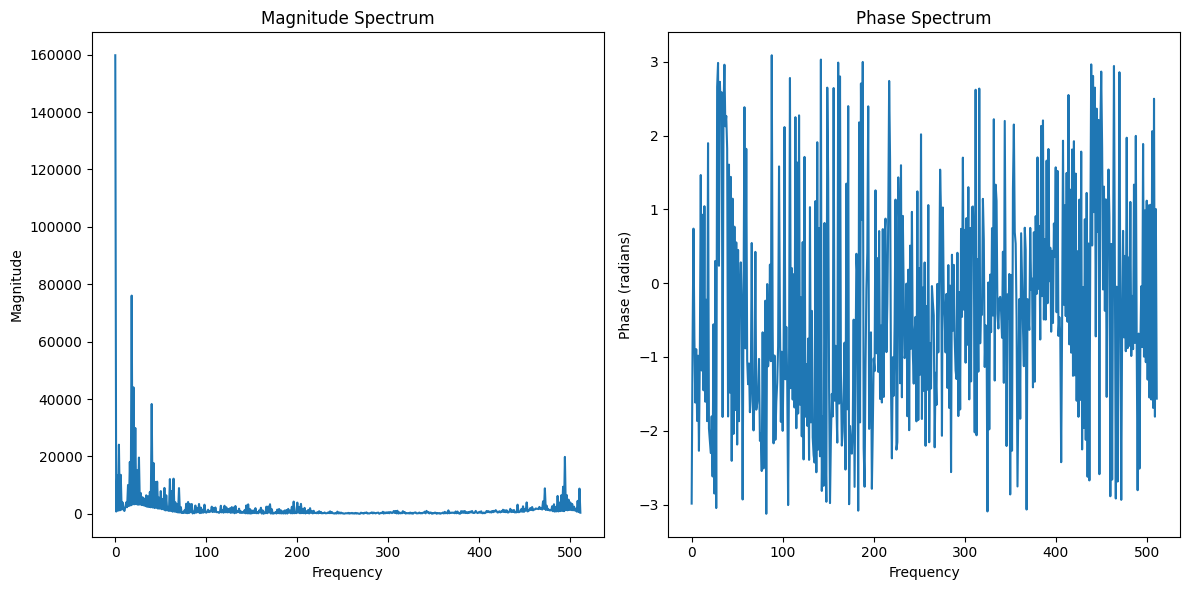

In [75]:
complex_range_profiles = [np.fft.fft(first_chirp) for first_chirp in first_chirps_of_frame]
magnitudes = [np.abs(complex_range_profile) for complex_range_profile in complex_range_profiles]
angles = [np.angle(complex_range_profile) for complex_range_profile in complex_range_profiles]
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(magnitudes[0])
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.title('Magnitude Spectrum')

plt.subplot(122)
plt.plot(angles[0])
plt.xlabel('Frequency')
plt.ylabel('Phase (radians)')
plt.title('Phase Spectrum')

plt.tight_layout()

In [76]:
# range-slow time matrix

range_slow_time_m_x_n = [np.fft.fft(first_chirp) for first_chirp in first_chirps_of_frame]


In [94]:
# calculate DC 
org_range_slow_time_m_x_n = copy.deepcopy(range_slow_time_m_x_n)
corrected_range_slow_time_m_x_n = np.empty(shape=np.array(range_slow_time_m_x_n).shape, dtype=complex)

range_bins=np.array(range_slow_time_m_x_n).shape[1]
DC_ranges=  np.empty(range_bins, dtype='object')
print("check ",range_bins," bin")
for r_th in range(0,range_bins):
    # print("check ",r_th,"th bin")
    range_bin_r_th =np.array(range_slow_time_m_x_n)[:,r_th]
    avg_re_I= np.mean(np.real(range_bin_r_th))
    avg_im_Q= np.mean(np.imag(range_bin_r_th))
    DC_ranges[r_th]=avg_re_I +  avg_im_Q*1j


check  512  bin


In [95]:
print(np.array(DC_ranges).shape)

(512,)


In [97]:
#DC correction

for i_th in range(0,range_bins):
    DC=DC_ranges[i_th]    
    corrected_range_slow_time_m_x_n[:,i_th] = np.array(range_slow_time_m_x_n)[:,i_th] -DC
    


print(corrected_range_slow_time_m_x_n[0])



[ 2.06400633e+03+1.57807300e+03j  4.67440816e+01-9.85827804e+01j
  1.89036880e+03+1.94804179e+03j  3.20195159e+01-1.75827801e+00j
  1.81985679e+03+2.08160286e+03j -3.48920369e+01+7.44852376e+00j
  2.15874485e+03+2.28722999e+03j -1.98800115e+01-5.08354198e+00j
  2.47188287e+03+2.58865951e+03j  1.67062186e+02+1.34945866e+02j
  3.06732384e+03+3.07455680e+03j  1.63551318e+02-1.01198246e+02j
  4.05266560e+03+3.94189356e+03j -8.25017325e+01+1.03165307e+01j
  4.21699141e+03+7.78288127e+03j  2.65249143e+01-8.44482080e+01j
  1.83527326e+04-5.16156815e+03j -1.09235231e+02-3.29168880e+01j
 -1.93499279e+04+7.20856704e+04j  1.68815858e+02-3.06853413e+02j
 -2.60594509e+04-3.17014928e+04j -1.09167524e+02-1.08749991e+02j
 -1.60592437e+04-7.81867399e+03j -1.53544651e+02+5.57824582e+01j
 -7.02500867e+03-1.29600417e+04j  1.36254577e+01+1.81619239e+02j
 -4.44660610e+03+6.41018044e+03j  1.32348253e+00+5.31628175e+01j
 -7.56825627e+03-9.43054800e+03j  9.29964331e+00+9.98585283e+01j
  1.15462882e+04+3.152604

In [98]:
# print("org: ",org_range_slow_time_m_x_n[0])
# print("corrected: ",corrected_range_slow_time_m_x_n[0])
print("diff: ",org_range_slow_time_m_x_n[0] - corrected_range_slow_time_m_x_n[0])


diff:  [-1.59898006e+05-2.63960730e+04j  4.97038532e+02-4.89332697e+02j
  8.04890451e+03+7.10231910e+03j  7.83928116e+02-7.27000646e+02j
 -2.93200302e+03-2.61431358e+04j  7.94568560e+02-9.53868883e+02j
 -6.12374588e+03-1.52866186e+04j  8.27311663e+02-1.20390309e+03j
 -5.03204104e+03-5.63215997e+03j  8.13785687e+02-1.54359440e+03j
 -2.96229893e+03-2.08745185e+03j  6.69362881e+02-1.93632388e+03j
 -1.65106526e+03-7.42972460e+02j  3.59879893e+02-2.31551128e+03j
  8.50206978e+02+8.96149027e+02j -1.21239421e+02-2.63062410e+03j
 -7.25763979e+02+1.13986486e+03j -7.56072007e+02-2.78144284e+03j
 -4.94756045e+03-4.05435833e+01j -1.42385526e+03-2.68170514e+03j
  2.30331222e+03-5.43051540e+03j -2.10868296e+03-2.37017100e+03j
  9.14801763e+03-2.12805036e+04j -2.74718240e+03-1.73126984e+03j
  1.99144241e+04+4.92740877e+03j -3.03075283e+03-1.09006134e+03j
  2.31661628e+04-5.92398232e+02j -3.21757503e+03-3.62216149e+02j
  1.14175990e+03+1.27942364e+04j -3.02663000e+03+3.82742208e+02j
 -5.95147563e+03-1

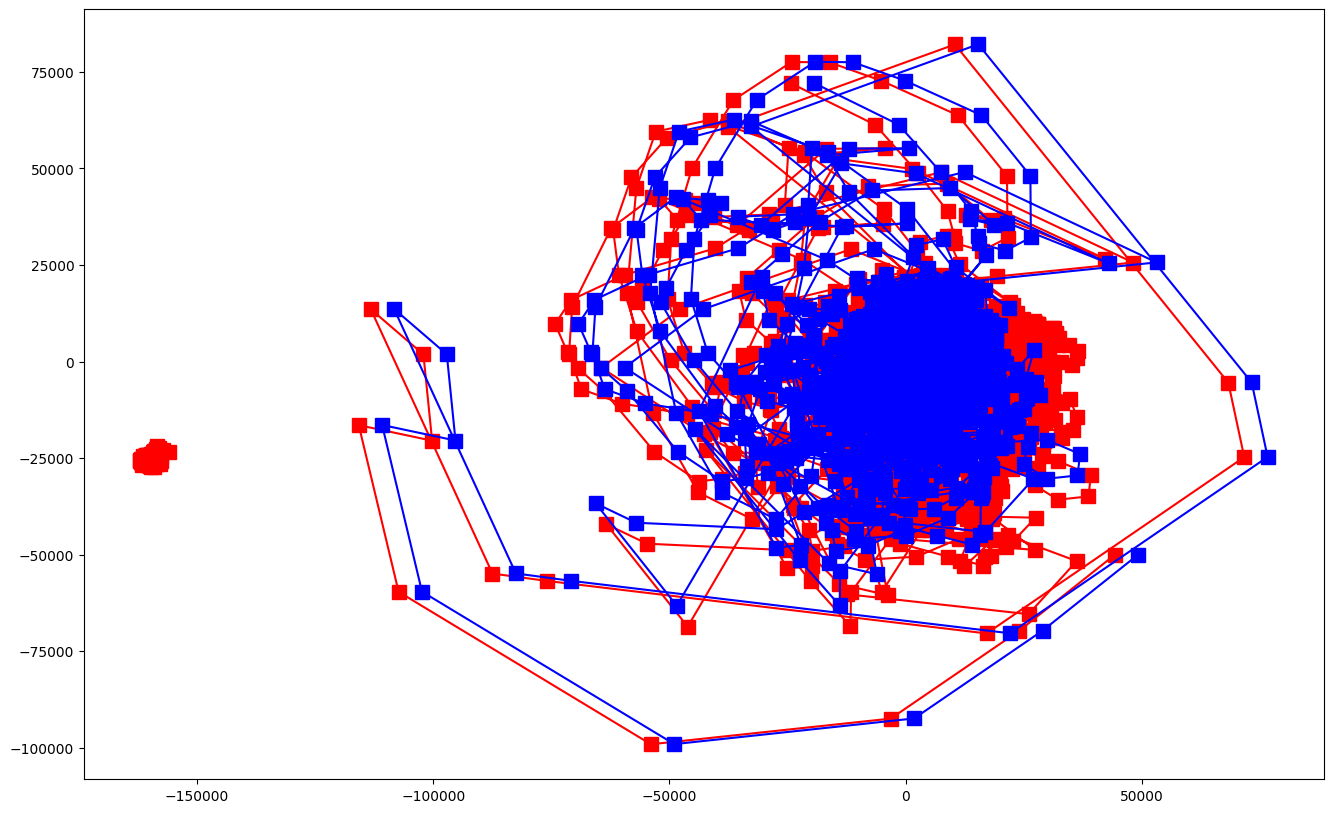

In [100]:
tmp_org_range_slow_time_m_x_n =org_range_slow_time_m_x_n[0:200]
DC_real_parts = [z.real for z in tmp_org_range_slow_time_m_x_n]
DC_imaginary_parts = [z.imag for z in tmp_org_range_slow_time_m_x_n]

tmp_range_slow_time_m_x_n =corrected_range_slow_time_m_x_n[0:200]
DC_corrected_real_parts = [sl.real for sl in tmp_range_slow_time_m_x_n]
DC_corrected_imaginary_parts = [sl.imag for sl in tmp_range_slow_time_m_x_n]



plt.figure(figsize=(16, 10))

plt.plot(DC_real_parts, DC_imaginary_parts, 'rs-', markeredgewidth=1, markersize=10,linewidth=0)
plt.plot(DC_real_parts, DC_imaginary_parts, color='red')

plt.plot(DC_corrected_real_parts, DC_corrected_imaginary_parts, 'bs-', markeredgewidth=1, markersize=10,linewidth=0)
plt.plot(DC_corrected_real_parts, DC_corrected_imaginary_parts, color='blue')
plt.show()


In [101]:
print(tmp_range_slow_time_m_x_n[0])

[ 2.06400633e+03+1.57807300e+03j  4.67440816e+01-9.85827804e+01j
  1.89036880e+03+1.94804179e+03j  3.20195159e+01-1.75827801e+00j
  1.81985679e+03+2.08160286e+03j -3.48920369e+01+7.44852376e+00j
  2.15874485e+03+2.28722999e+03j -1.98800115e+01-5.08354198e+00j
  2.47188287e+03+2.58865951e+03j  1.67062186e+02+1.34945866e+02j
  3.06732384e+03+3.07455680e+03j  1.63551318e+02-1.01198246e+02j
  4.05266560e+03+3.94189356e+03j -8.25017325e+01+1.03165307e+01j
  4.21699141e+03+7.78288127e+03j  2.65249143e+01-8.44482080e+01j
  1.83527326e+04-5.16156815e+03j -1.09235231e+02-3.29168880e+01j
 -1.93499279e+04+7.20856704e+04j  1.68815858e+02-3.06853413e+02j
 -2.60594509e+04-3.17014928e+04j -1.09167524e+02-1.08749991e+02j
 -1.60592437e+04-7.81867399e+03j -1.53544651e+02+5.57824582e+01j
 -7.02500867e+03-1.29600417e+04j  1.36254577e+01+1.81619239e+02j
 -4.44660610e+03+6.41018044e+03j  1.32348253e+00+5.31628175e+01j
 -7.56825627e+03-9.43054800e+03j  9.29964331e+00+9.98585283e+01j
  1.15462882e+04+3.152604

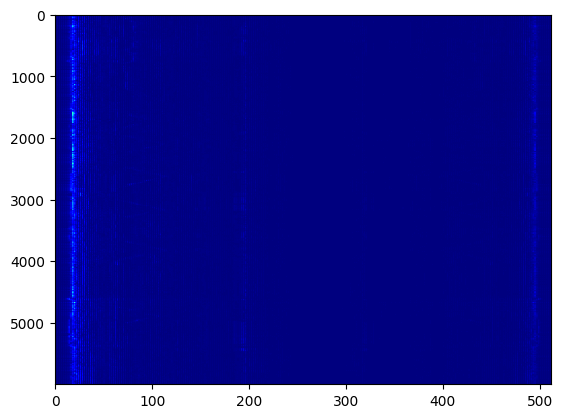

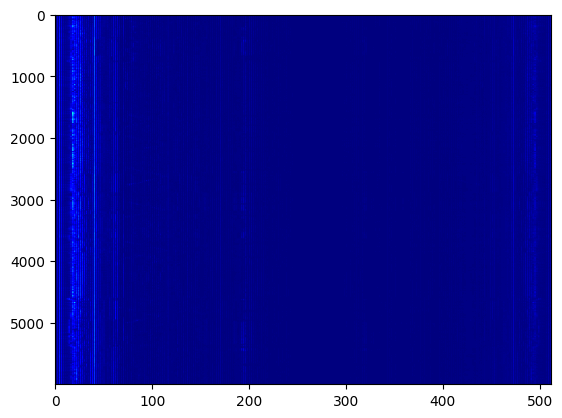

In [102]:
magnitude_corrected_ffts = [np.abs(corrected_fft) for corrected_fft in corrected_range_slow_time_m_x_n]
magnitude_org_ffts = [np.abs(org) for org in org_range_slow_time_m_x_n]

plt.imshow(magnitude_corrected_ffts, cmap='jet', aspect='auto')
plt.show()
plt.imshow(magnitude_org_ffts, cmap='jet', aspect='auto')
plt.show()

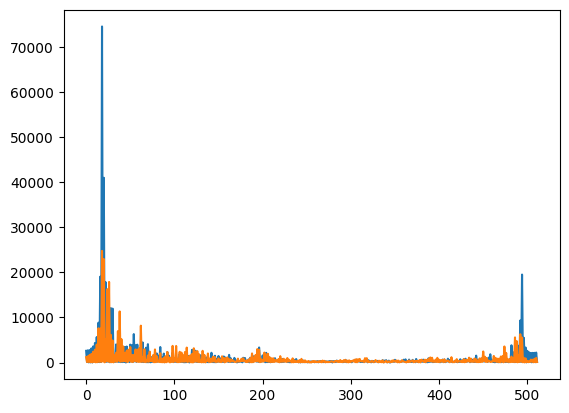

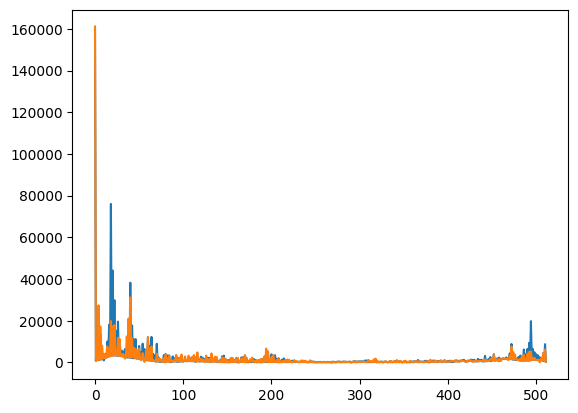

In [105]:
plt.plot(magnitude_corrected_ffts[0])
plt.plot(magnitude_corrected_ffts[-1])
plt.show()
plt.plot(magnitude_org_ffts[0])
plt.plot(magnitude_org_ffts[-1])
plt.show()